# Data Prepare

# 定义一些可视化函数
`%matplotlib inline` 是 Jupyter Notebook 中的魔术命令之一，它用于指定在 notebook 中嵌入 matplotlib 绘图，并且在执行代码块后直接在 notebook 中显示图形输出，而不需要使用 `plt.show()` 函数。

具体而言：

- `%matplotlib` 是 Jupyter 中用于控制 matplotlib 图形的魔术命令。
- `inline` 表示要将图形嵌入到 notebook 中，而不是弹出一个新的窗口显示图形。

这使得在 notebook 中运行的代码块中生成的图形能够直接显示在代码块下方，而无需额外的显示命令。这对于数据可视化和图形分析来说非常方便。

In [1]:
from torch._C import device
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid("./data/Planetoid", "PubMed")
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3


In [3]:
data = dataset[0]  # Get the first graph object.

print(data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


- 图的表示用[`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)格式（说明可以点击）

### edge_index
- edge_index：表示图的连接关系（start,end两个序列）
- node features：每个点的特征
- node labels：每个点的标签
- train_mask：有的节点木有标签（用来表示哪些节点要计算损失）

In [4]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[    0,  1378],
        [    0,  1544],
        [    0,  6092],
        ...,
        [19714, 12278],
        [19715,  4284],
        [19716, 16030]])


#### 使用networkx可视化展示

KeyboardInterrupt: 

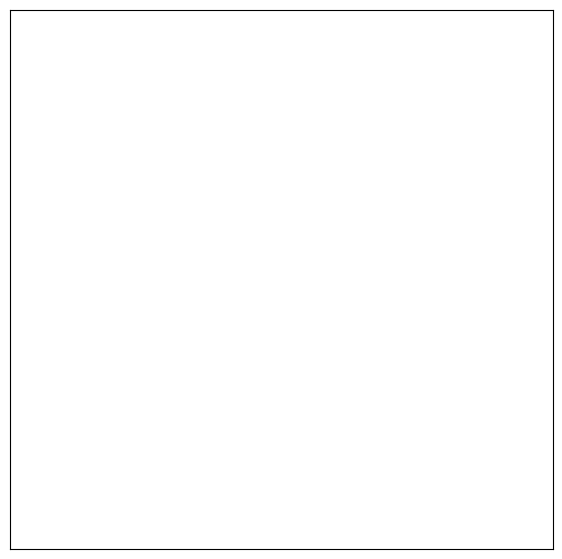

In [5]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

### Graph Neural Networks 网络定义：
- **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) 定义如下：
$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$
- PyG 文档 [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

In [6]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # torch.manual_seed(1234) 是 PyTorch 中用于设置随机数种子的函数。通过设置随机数种子，
        # 可以使得每次运行代码时生成的随机数相同，从而实现代码的可重复性。
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4) # 只需定义好输入特征和输出特征即可
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 8)
        self.classifier = Linear(8, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index) # 输入特征与邻接矩阵（注意格式，上面那种）
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  
        
        # 分类层
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(500, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 8)
  (classifier): Linear(in_features=8, out_features=3, bias=True)
)


### 输出特征展示
- 最后不是输出了两维特征嘛，画出来看看长啥样
- 但是，但是，现在咱们的模型还木有开始训练。。。

Embedding shape: [19717, 8]


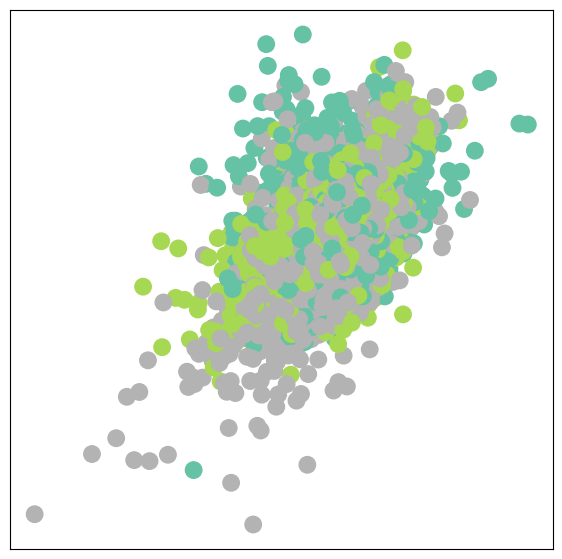

In [7]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

### 训练模型(semi-supervised)

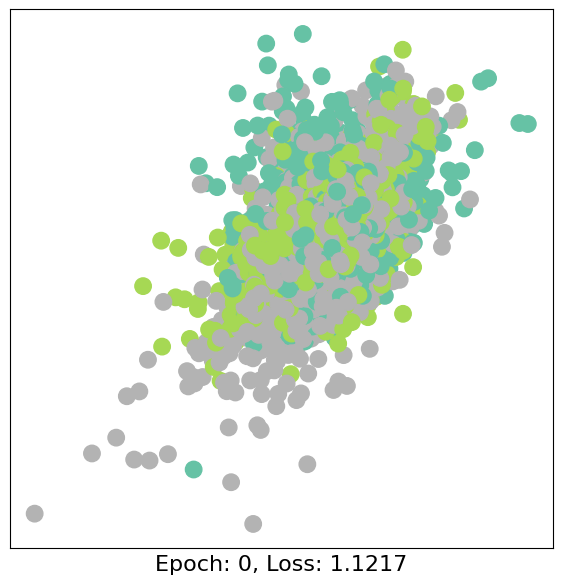

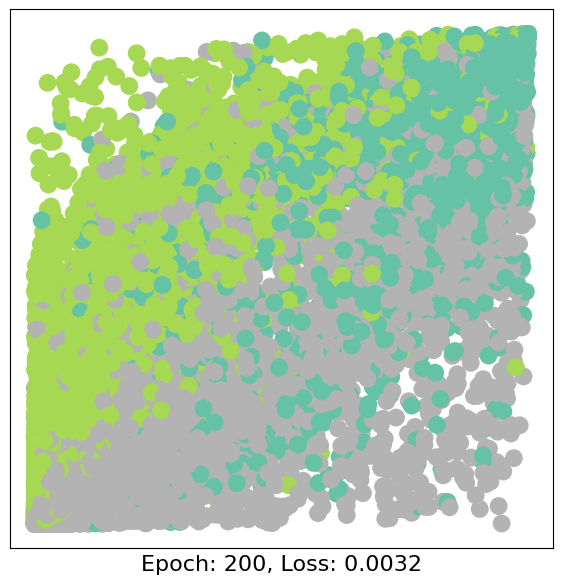

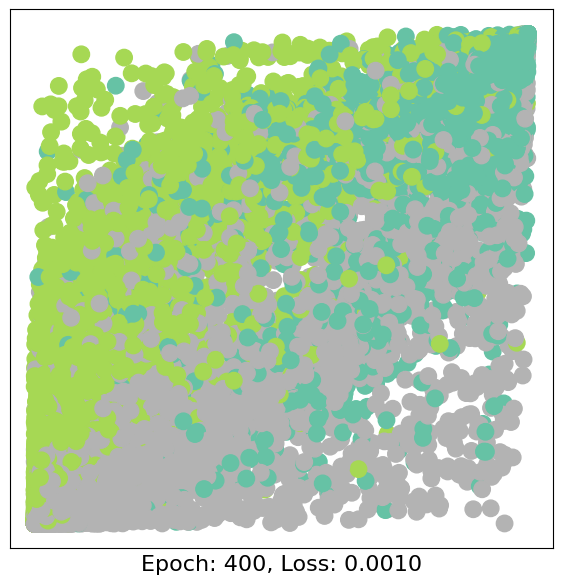

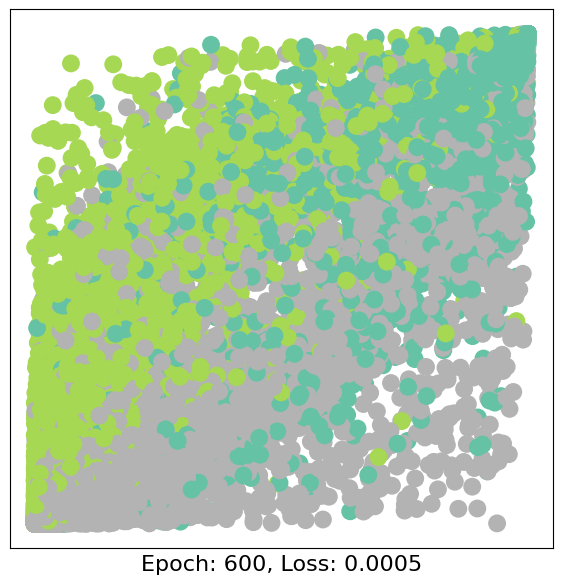

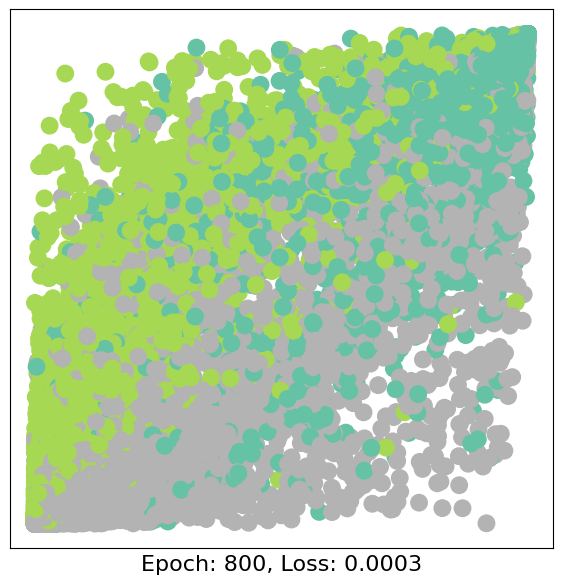

In [8]:
import time


model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  
    out, h = model(data.x, data.edge_index) #h是两维向量，主要是为了咱们画个图 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # semi-supervised
    loss.backward()  
    optimizer.step()  
    return loss, h


for epoch in range(801):
    loss, h = train(data)
    if epoch % 200 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)